You are supposed to train and apply a boosting model for landcover classification. Below, you can find some code that already parses the data. For your submission, run and submit the extended jupyter notebook.

In [2]:
import numpy as np

In [7]:
# load data
train = np.load('./train.npz')
X_train = train["X"]
y_train = train["y"]

test = np.load('./test.npz')
X_test = test["X"]
y_test = test["y"]

classes = {
    1: "cultivated_land",
    2: "forest",
    3: "grassland",
    4: "shrubland",
    5: "water",
    8: "artificial_surface",
    9: "bareland"
}


In [9]:
print("Shape of training data: {}".format(X_train.shape))
print("Shape of training labels: {}".format(y_train.shape))
print("Shape of test data: {}".format(X_test.shape))
print("Shape of test labels: {}".format(y_test.shape))
np.unique(y_train, return_counts = True)

Shape of training data: (6953, 12, 13, 13, 6)
Shape of training labels: (6953,)
Shape of test data: (1739, 12, 13, 13, 6)
Shape of test labels: (1739,)


(array([1, 2, 3, 4, 5, 8, 9], dtype=uint8),
 array([ 194, 4641,  901,  617,   45,  175,  380], dtype=int64))

The training and test set contain a few thousand instances. Each instance is based on image of size 13x13 pixels, which are available for 12 timestamps and 6 bands. That is, one is given an array of shape (12,13,13,6) for each instance. The label arrays contain the labels associated with the instances, where the central pixel/position determines the class of the (whole) image array for each instance, see below.

Label (i.e., class of pixel in the center of the images) for image sequence: forest


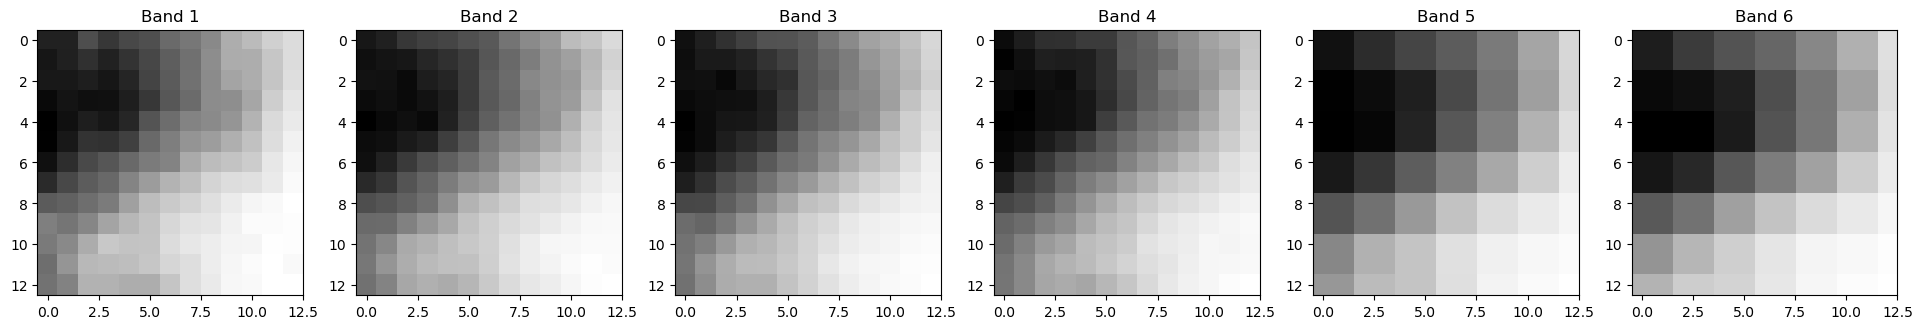

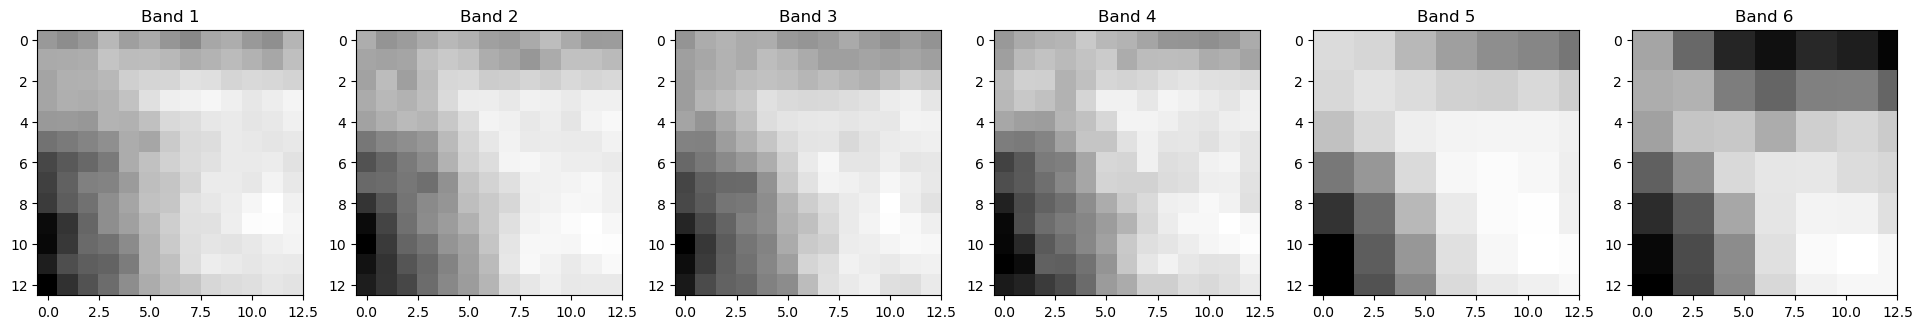

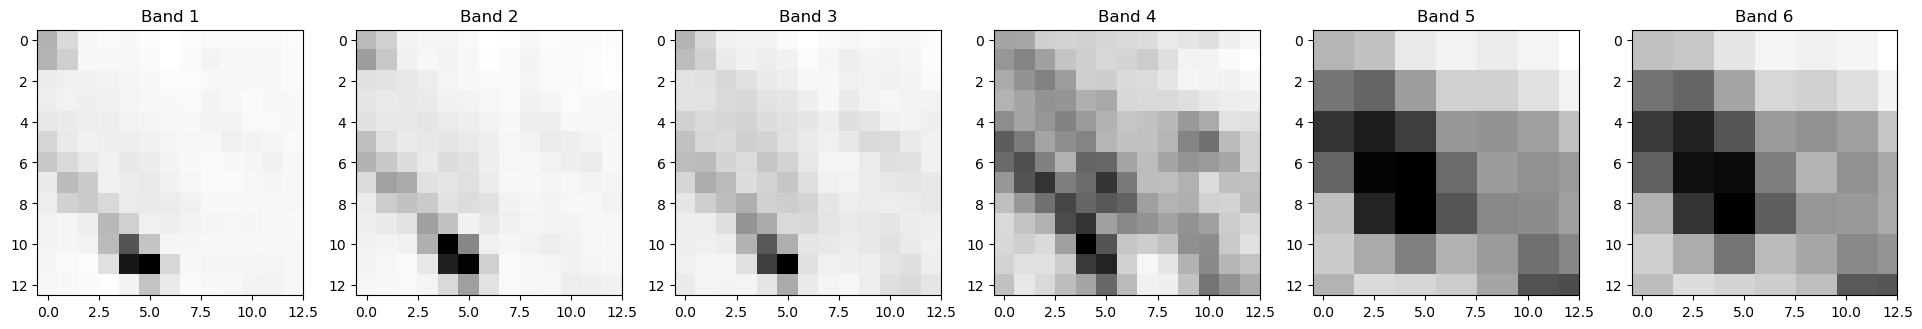

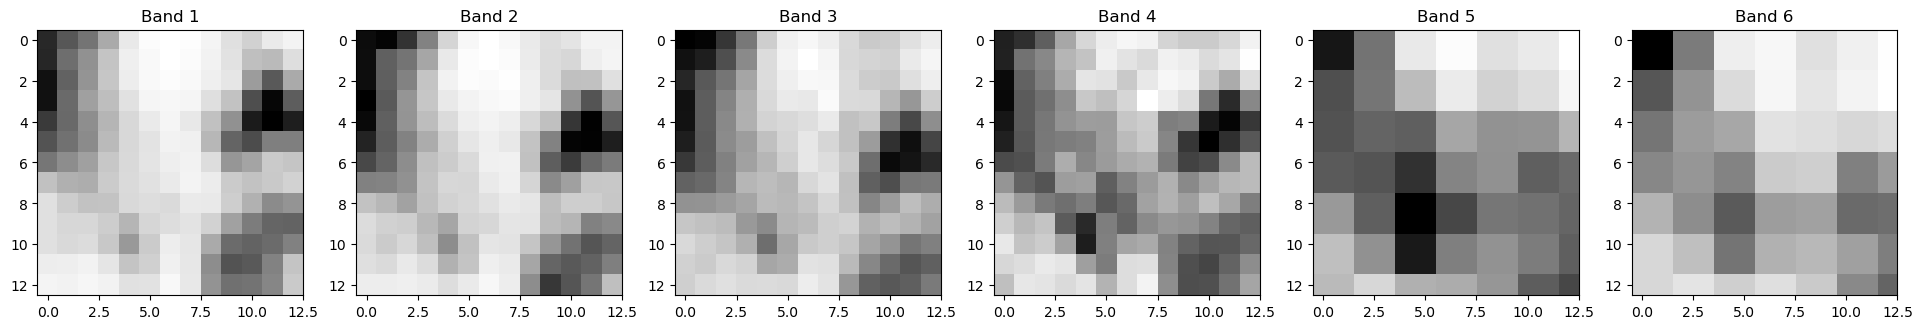

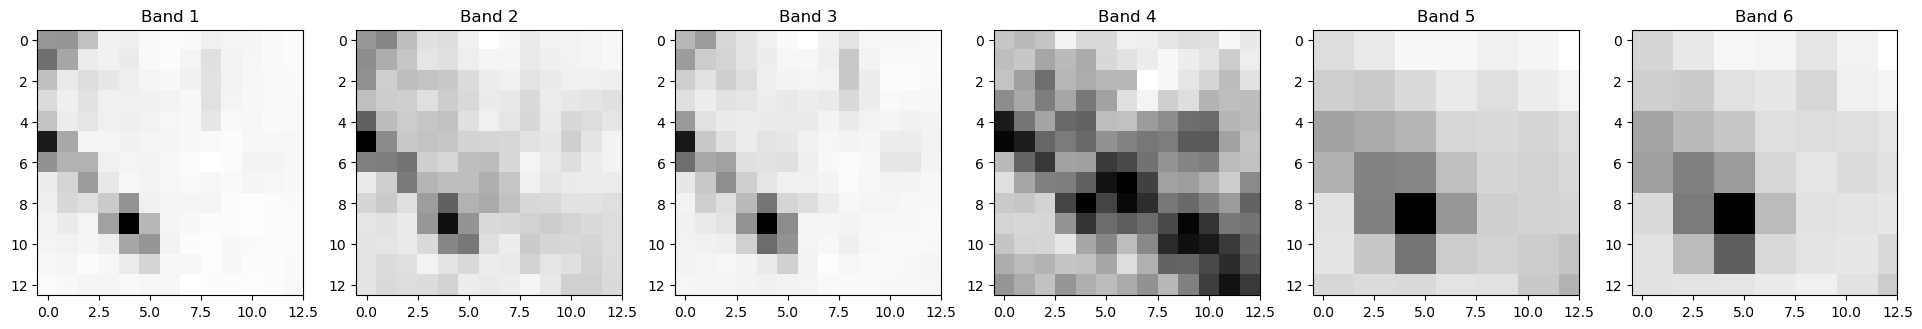

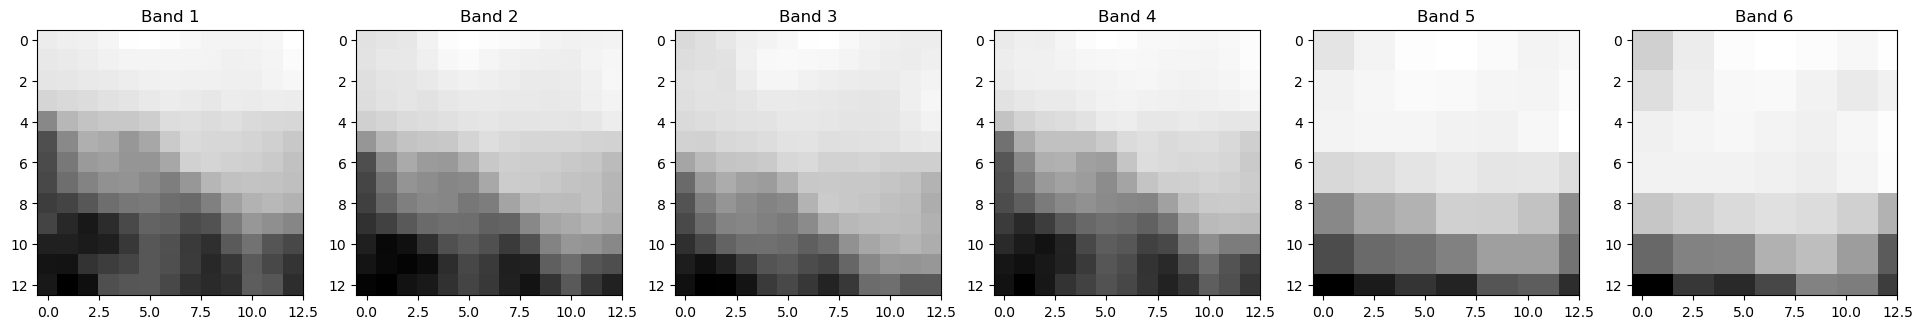

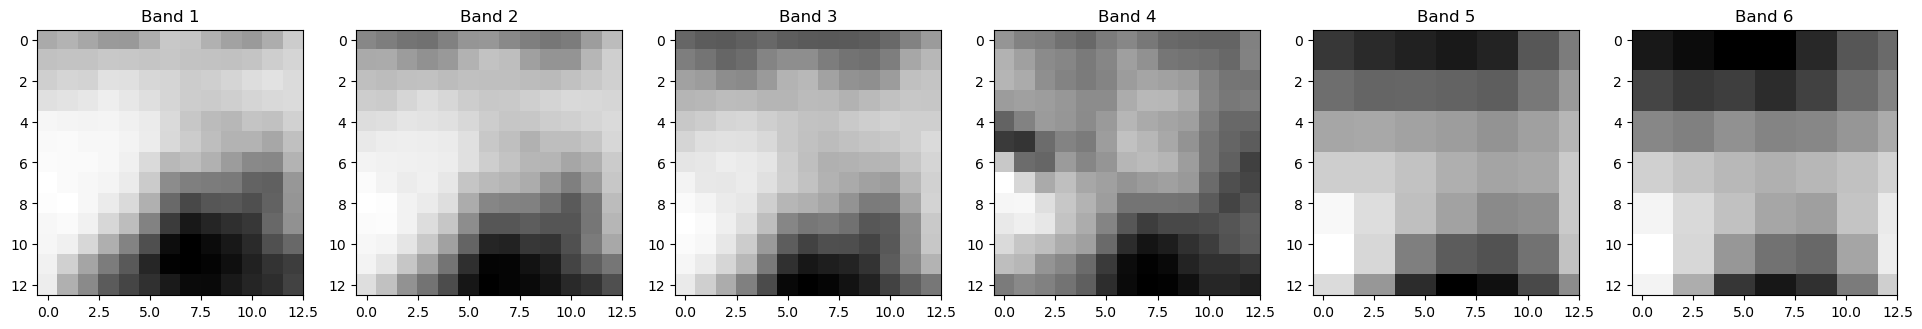

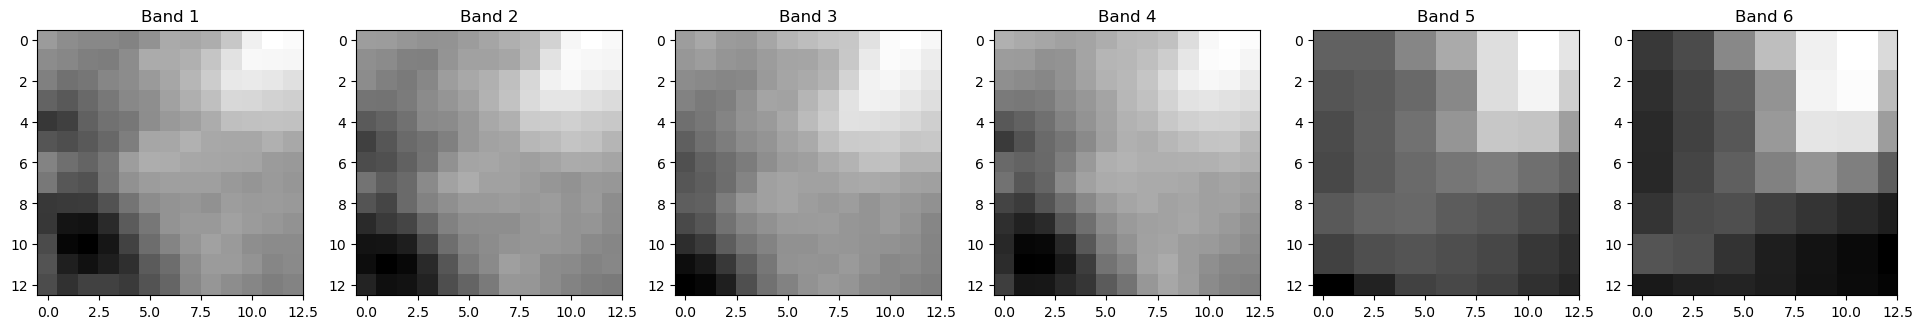

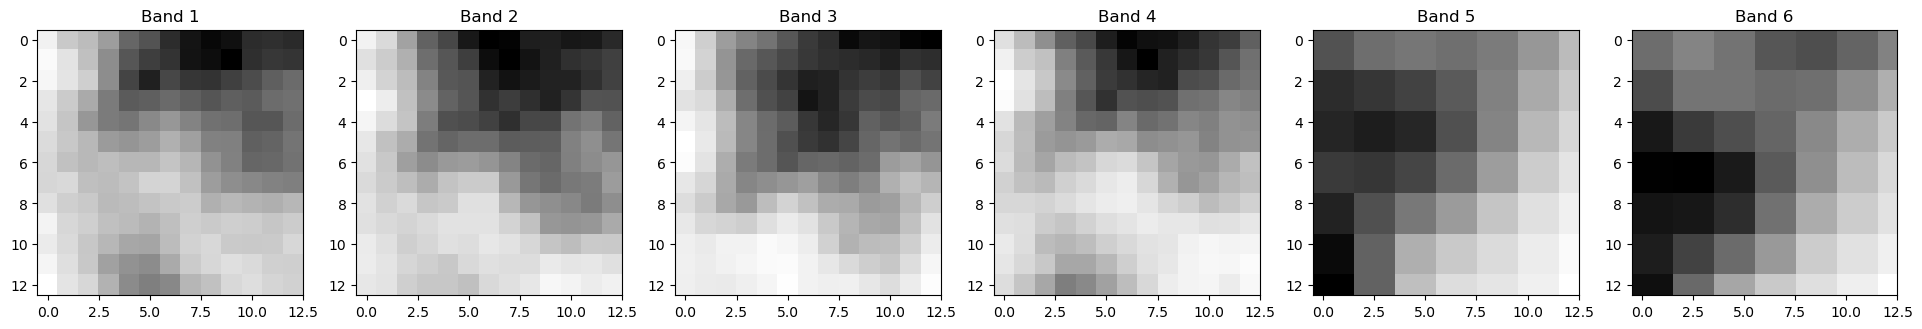

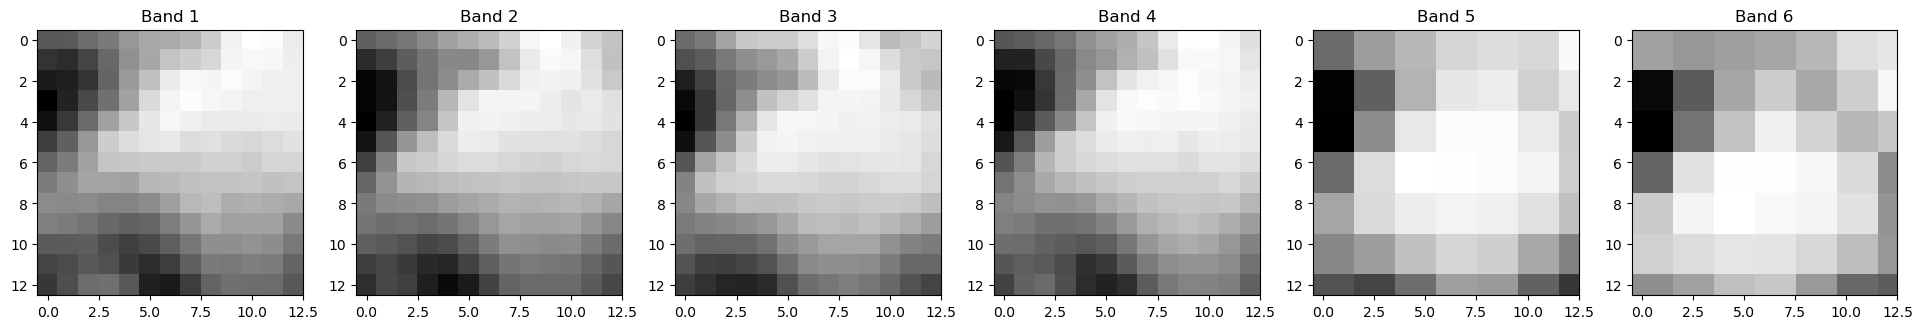

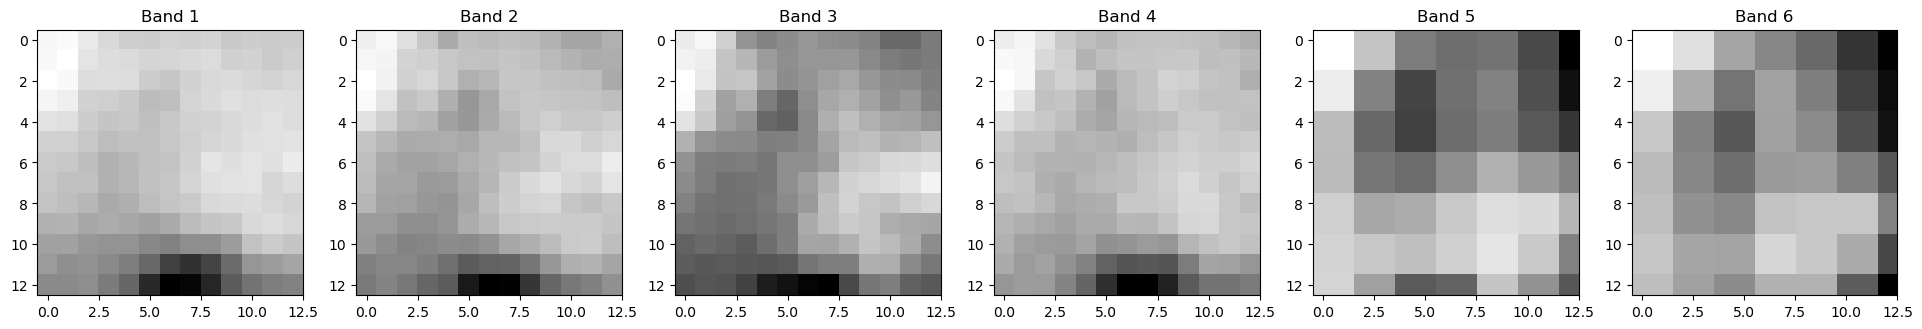

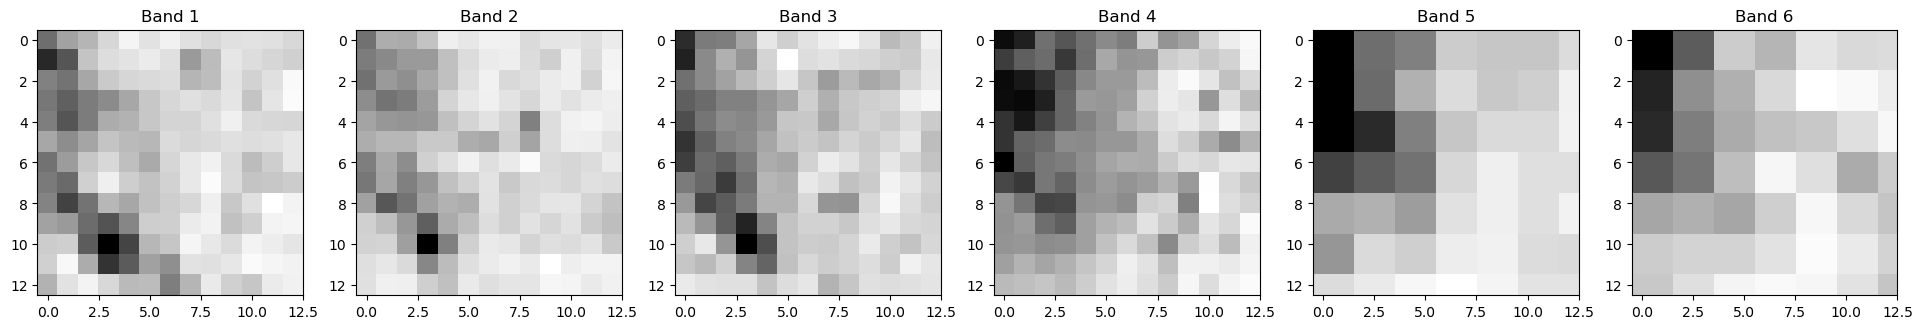

In [39]:
# visualize some of the (image) data

import matplotlib.cm as cm
import matplotlib.pyplot as plt

idx = 0

print("Label (i.e., class of pixel in the center of the images) for image sequence: {}".format(classes[y_train[idx,0]]))

for year in range(12):
    fig, axs = plt.subplots(1, 6, figsize=(24, 4))
    for b in range(6):
        axs[b].imshow(X_train[idx, year, :, :, b], cmap=plt.get_cmap("Greys"))
        axs[b].set_title("Band {}".format(b+1))

In [10]:
# Flatten the data, 13*13*12*6= 12168
X_train_flat = np.reshape(X_train, (6953,12168), order = "C") 
X_test_flat = np.reshape(X_test, (1739,12168), order = "C")

In [11]:
# split into training and validation set
from sklearn.model_selection import train_test_split
X_train_flat, X_eval_flat, y_train, y_eval = train_test_split(X_train_flat, y_train,
 test_size=0.1, random_state=120) 

In [18]:
import xgboost as xgb
classifier = xgb.XGBClassifier(objective = "multi:softmax", colsample_bytree=0.02, learning_rate=0.1, max_depth=8,
reg_lambda=1, n_estimators=100, eval_metric = "mlogloss")

# Fit XGBClassifier to training set and evaluate validation error on validation set
classifier.fit(X_train_flat, y_train, eval_set=[(X_eval_flat, y_eval), (X_train_flat, y_train)]) 

c:\Users\asr\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-mlogloss:1.74636	validation_1-mlogloss:1.69983
[1]	validation_0-mlogloss:1.59193	validation_1-mlogloss:1.51196
[2]	validation_0-mlogloss:1.47107	validation_1-mlogloss:1.35642
[3]	validation_0-mlogloss:1.37265	validation_1-mlogloss:1.22770
[4]	validation_0-mlogloss:1.28912	validation_1-mlogloss:1.11878
[5]	validation_0-mlogloss:1.21506	validation_1-mlogloss:1.02346
[6]	validation_0-mlogloss:1.15215	validation_1-mlogloss:0.93888
[7]	validation_0-mlogloss:1.09484	validation_1-mlogloss:0.86552
[8]	validation_0-mlogloss:1.04477	validation_1-mlogloss:0.79895
[9]	validation_0-mlogloss:0.99948	validation_1-mlogloss:0.73962
[10]	validation_0-mlogloss:0.95996	validation_1-mlogloss:0.68631
[11]	validation_0-mlogloss:0.92488	validation_1-mlogloss:0.63702
[12]	validation_0-mlogloss:0.89461	validation_1-mlogloss:0.59287
[13]	validation_0-mlogloss:0.86843	validation_1-mlogloss:0.55311
[14]	validation_0-mlogloss:0.84113	validation_1-mlogloss:0.51591
[15]	validation_0-mlogloss:0.81813	

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.02,
              enable_categorical=False, eval_metric='mlogloss', gamma=0,
              gpu_id=-1, importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_class=7, num_parallel_tree=1,
              objective='multi:softprob', predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, ...)

In [19]:
from matplotlib import pyplot as plt
# Visualise results
evals = classifier.evals_result() # Get RMSEs
val_errors = np.array(evals["validation_0"]["mlogloss"]) # Convert validation errors to np array
train_errors = np.array(evals["validation_1"]["mlogloss"]) # Convert training errors to np array

plt.plot(np.arange(1,len(val_errors)+1), val_errors, label = "Validation error")
plt.plot(np.arange(1,len(train_errors)+1), train_errors, label = "Training error")
plt.grid()
plt.legend()
plt.xlabel("Boosting iterations")
plt.ylabel("Multiclass logloss")
plt.savefig("boost1.png")
plt.close()


In [20]:
pred = classifier.predict(X_test_flat)
print("Accuracy is:", np.mean(pred == y_test))
print("Accuracy w. score method:", classifier.score(X_test_flat, y_test))

Accuracy is: 0.8217366302472685
Accuracy w. score method: 0.8217366302472685


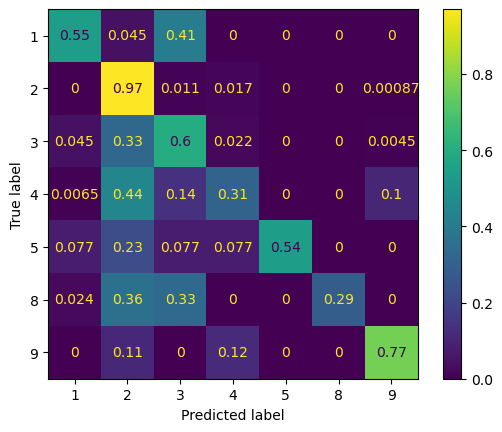

In [17]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_test, pred,normalize = "true")
plt.savefig("confusion_matrix.png")